In [1]:
import numpy as np
import pandas as pd
import datetime
from sklearn import preprocessing
from datetime import datetime
from sklearn.svm import SVC
import operator
import googlefinance.client as gfc
from matplotlib import pyplot as plt

from sklearn import linear_model
from sklearn.model_selection import train_test_split

from sklearn.ensemble import RandomForestRegressor

import quandl

%matplotlib notebook

The goal of this notebook is to create time series regression models using some regression models as well as "Forest" models (both regression and deep learning versions). 

The features for this part of the research are going to be extracted using data freely available in Python via Quandl and pandas Yahoo finance support. 

- NASDAQ Composite
- Dow Jones Industrial Average
- Frankfurt DAX
- London FTSE-100
- Paris CAC 40
- Tokyo Nikkei-225
- Hong Kong Hang Seng
- Australia ASX-200

The features will be extracted from the major market indicators above will have the following format:

- Date : in days

- Open : price of the stock at the opening of the trading (in US dollars)
- High : highest price of the stock during the day (in US dollars)
- Low : lowest price of the stock during the trading day (in US dollars)
- Close : price of the stock at the closing of the trading (in US dollars)
- Volume : amount of stocks traded (in US dollars)
- Adj Close : price of the stock at the closing of the trading adjusted with dividends (in US dollars)

In [2]:
# Get googlefinance major global ETF data

period = "12M"

params = [
    {'q': "IXIC",
     'x': 'INDEXNASDAQ'
    },
    {'q': '.DJI',
      'x': 'INDEXDJX'  
    },
    {'q':'DAX',
     'x':'INDEXDB'   
    },
    {'q': 'UKX',
      'x':'INDEXFTSE'   
    },
    {'q': 'PX1',
      'x': 'INDEXEURO'   
    },
    {'q': 'NI225',
      'x': 'INDEXNIKKEI'  
    },
    {'q': 'HSI',
      'x': 'INDEXHANGSENG'  
    },
    {'q': 'XJO',
      'x':'INDEXASX'   
    },
    {'q': "SPY",
     'x': 'NYSEARCA'
    }
]
feats1 = gfc.get_prices_data(params, period)
# Clear the null volume data
j = feats1.pop('IXIC_Volume')
j = feats1.pop('XJO_Volume')
feats1.shape

(261, 43)

In [3]:
# Get Interest rate yield curve pct_change
# Get inflation pct_change
# Get yields of ETFs (2nd stage)
# Get US GDP pct_change
# Get correlations of the signals listed with respct to SPY (or alternative ETFs listed in project)



# Currently, some placeholder data from quandl, going to replace with data mentioned above
quandl.ApiConfig.api_key = "a1LZ4iFxZS6mzZUsf28u"
feats2 = quandl.get('BEA/NIPA_2_8_7_M', start_date='2016-08-31',
                   end_date='2017-08-31')
feats1 = feats1.dropna()

In [4]:
x = feats1
y = feats2

In [5]:
y = y.resample('1D', 'ffill').reindex(x.index)

/Users/armanarkilic/anaconda/envs/dev/lib/python3.6/site-packages/ipykernel_launcher.py:1: FutureWarning: how in .resample() is deprecated
the new syntax is .resample(...).ffill()
  """Entry point for launching an IPython kernel.


In [6]:
for i in y.columns:
    x[i] = y[i]

In [7]:
x.head()
feats1 = x

In [8]:
feats1 = feats1.dropna()
y = feats1.pop('SPY_Close')
X = feats1

In [9]:
X.tail()

,IXIC_Open,IXIC_High,IXIC_Low,IXIC_Close,.DJI_Open,.DJI_High,.DJI_Low,.DJI_Close,.DJI_Volume,DAX_Open,...,Personal consumption expenditures (PCE),Goods,:Durable goods,:Nondurable goods,Services,PCE excluding food and energy (Addenda),Food (Addenda),Energy goods and services (Addenda),Market-based PCE (Addenda),Market-based PCE excluding food and energy (Addenda)
2017-06-26,6292.733322,6303.445204,6233.429480,6247.149314,21434.68,21506.21,21381.25,21409.55,241881336.0,12783.89,...,0.0,-0.6,-0.2,-0.8,0.2,0.1,0.0,-3.1,-0.1,0.0
2017-06-27,6227.901271,6234.317136,6146.622667,6146.622667,21411.19,21440.60,21310.66,21310.66,292172136.0,12728.50,...,0.0,-0.6,-0.2,-0.8,0.2,0.1,0.0,-3.1,-0.1,0.0
2017-06-28,6173.102630,6238.290863,6144.798302,6234.414328,21372.36,21478.75,21372.36,21454.61,271510863.0,12586.06,...,0.0,-0.6,-0.2,-0.8,0.2,0.1,0.0,-3.1,-0.1,0.0
2017-06-29,6215.487948,6216.603778,6087.809991,6144.351113,21487.38,21487.38,21197.08,21287.03,336748500.0,12707.48,...,0.0,-0.6,-0.2,-0.8,0.2,0.1,0.0,-3.1,-0.1,0.0
2017-06-30,6166.835225,6170.628157,6129.036609,6140.420121,21348.60,21426.12,21325.08,21349.63,313257748.0,12424.50,...,0.0,-0.2,-0.2,-0.2,0.1,0.1,-0.1,-1.7,0.0,0.1


In [10]:
y = y.shift(1).dropna()

In [11]:
X = X[:-1]

In [12]:
X.shape, y.shape

((177, 52), (177,))

In [13]:
# Use 95% to train of the 12 month data set

# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=42)
training_range = int(X.shape[0] *.95)
X_train = X[0:training_range]
y_train = y[0:training_range]

X_test = X[training_range: ]
y_test = y[training_range: ]

In [14]:
X_train.head()

,IXIC_Open,IXIC_High,IXIC_Low,IXIC_Close,.DJI_Open,.DJI_High,.DJI_Low,.DJI_Close,.DJI_Volume,DAX_Open,...,Personal consumption expenditures (PCE),Goods,:Durable goods,:Nondurable goods,Services,PCE excluding food and energy (Addenda),Food (Addenda),Energy goods and services (Addenda),Market-based PCE (Addenda),Market-based PCE excluding food and energy (Addenda)
2016-09-07,5274.226046,5287.609816,5261.915529,5283.925895,18527.71,18536.89,18474.77,18526.14,67569967.0,10706.86,...,0.2,0.1,0.0,0.2,0.2,0.2,-0.1,-0.1,0.1,0.2
2016-09-08,5269.958705,5271.011497,5248.413358,5259.482653,18486.69,18506.24,18446.69,18479.91,79063230.0,10749.82,...,0.2,0.1,0.0,0.2,0.2,0.2,-0.1,-0.1,0.1,0.2
2016-09-09,5217.947467,5225.934856,5125.907877,5125.907877,18404.17,18404.17,18085.45,18085.45,120672714.0,10641.81,...,0.2,0.1,0.0,0.2,0.2,0.2,-0.1,-0.1,0.1,0.2
2016-09-12,5098.028137,5217.883598,5097.796041,5211.888353,18028.95,18358.69,17994.84,18325.07,103256877.0,10380.46,...,0.2,0.1,0.0,0.2,0.2,0.2,-0.1,-0.1,0.1,0.2
2016-09-13,5181.135245,5195.025360,5131.271234,5155.254930,18262.99,18262.99,18028.06,18066.75,102831049.0,10483.07,...,0.2,0.1,0.0,0.2,0.2,0.2,-0.1,-0.1,0.1,0.2


In [15]:
# The next day prediction
y_train.head()

2016-09-08    219.01
2016-09-09    218.51
2016-09-12    213.28
2016-09-13    216.34
2016-09-14    213.23
Name: SPY_Close, dtype: float64

# Ordinary Least Square

<IPython.core.display.Javascript object>


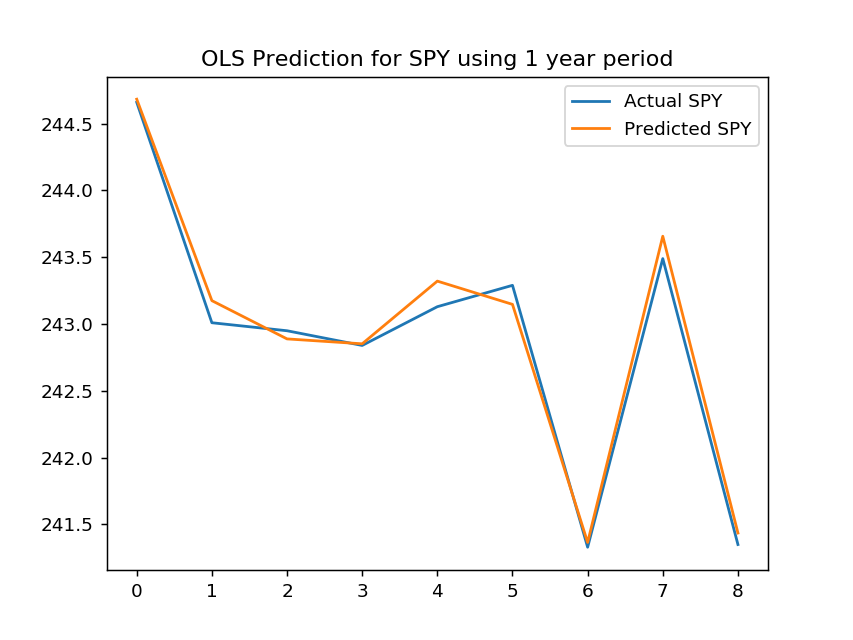

0.98529776684713899

In [16]:
reg = linear_model.LinearRegression()
reg.fit(X_train, y_train)
y_predicted = reg.predict(X_test)

fig, ax = plt.subplots()
ax.plot(y_test.values, label='Actual SPY')
ax.plot(y_predicted, label='Predicted SPY')
ax.set_title('OLS Prediction for SPY using 1 year period')
plt.legend()



reg.score(X_test, y_test)

# RidgeCV Method

<IPython.core.display.Javascript object>


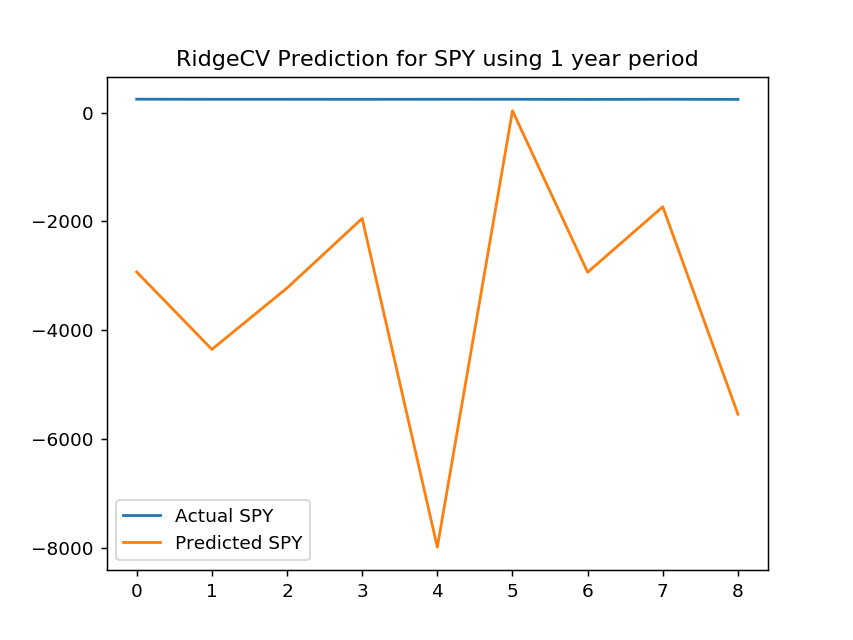

-19107075.382918488

In [17]:
ridge = linear_model.RidgeCV()
ridge.fit(X_train, y_train)
y_ridge_predicted = ridge.predict(X_test)

fig, ax = plt.subplots()
ax.plot(y_test.values, label='Actual SPY')
ax.plot(y_ridge_predicted, label='Predicted SPY')
ax.set_title('RidgeCV Prediction for SPY using 1 year period')
plt.legend()

ridge.score(X_test, y_test)

# Lasso 

/Users/armanarkilic/anaconda/envs/dev/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


<IPython.core.display.Javascript object>


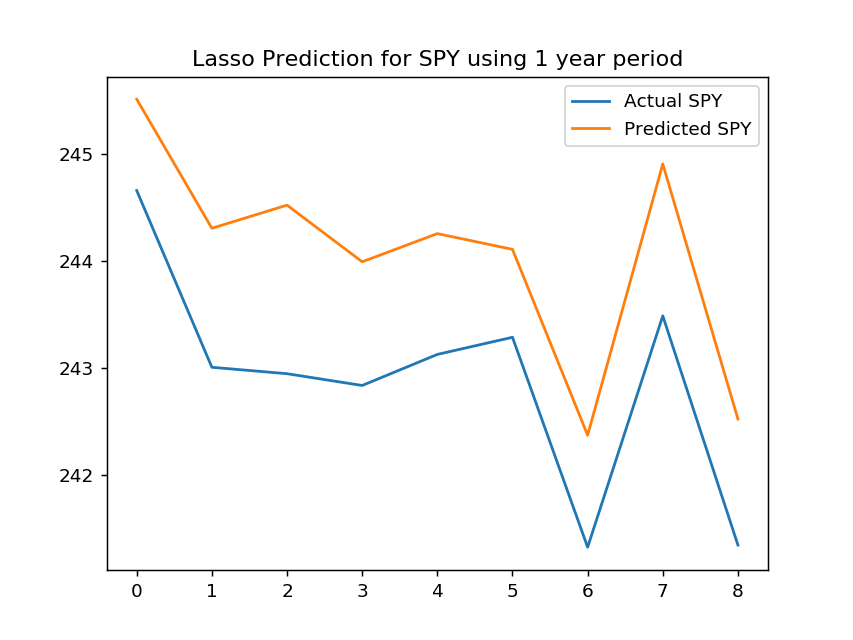

-0.48303979208806314

In [18]:
lasso = linear_model.Lasso(alpha = 1e-5)
lasso.fit(X_train, y_train)

y_predicted = lasso.predict(X_test)

fig, ax = plt.subplots()
ax.plot(y_test.values, label='Actual SPY')
ax.plot(y_predicted, label='Predicted SPY')
ax.set_title('Lasso Prediction for SPY using 1 year period')
plt.legend()

lasso.score(X_test, y_test)

# Random Forest Regressor

<IPython.core.display.Javascript object>


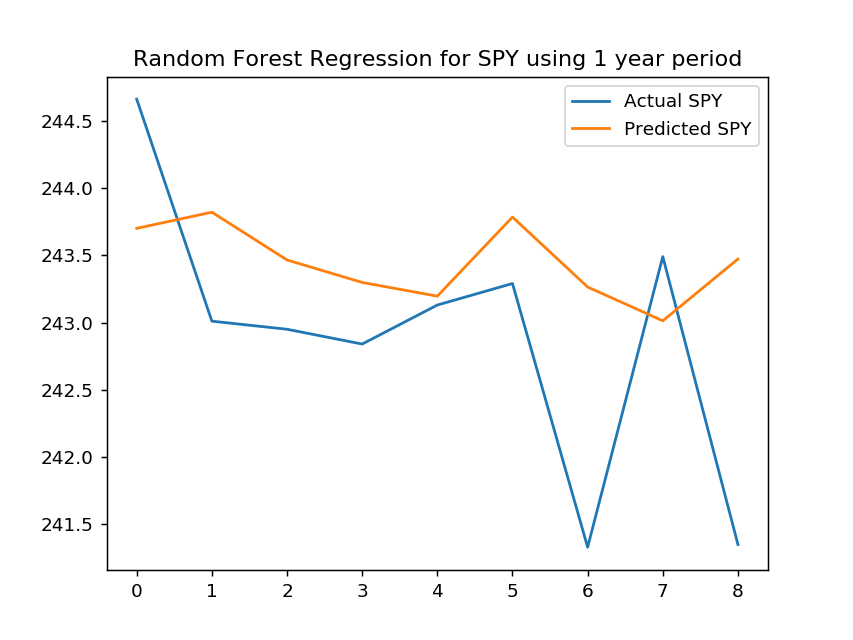

-0.26192853293623086

In [19]:
regr = RandomForestRegressor()
regr.fit(X_train, y_train)
regr_predicted = regr.predict(X_test)
fig, ax = plt.subplots()
ax.plot(y_test.values, label='Actual SPY')
ax.plot(regr_predicted, label='Predicted SPY')
ax.set_title('Random Forest Regression for SPY using 1 year period')
plt.legend()

regr.score(X_test, y_test)
